# Cycle GAN

サイクルGAN。ある分布に従うデータを別の分布に変換するモデル。

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from IPython.display import display
from tqdm import tqdm

batch_size = 32
n_per_line = 10 # number of images to display per line
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Horse to Zebra

In [2]:
image_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

horse2zebra = ImageFolder("./data/horse2zebra/train/", image_transform)
dataloader = DataLoader(horse2zebra, batch_size=batch_size, shuffle=True)

horse2zebra_test = ImageFolder("./data/horse2zebra/test/", image_transform)
test_loader = DataLoader(horse2zebra_test, batch_size=n_per_line, shuffle=True)

## U-Net

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1) # 128 x 128
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1) # 64 x 64
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1) # 32 x 32
        self.pool = nn.AdaptiveAvgPool2d(1) # 1 x 1

    def forward(self, x):
        z1 = self.conv1(x)
        z2 = self.conv2(z1)
        z3 = self.conv3(z2)
        y = self.pool(z3)
        return y, (z1, z2, z3)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(256, 256, 32, 1, 0) # 32 x 32
        self.conv2 = nn.ConvTranspose2d(256, 128, 4, 2, 1) # 64 x 64
        self.conv3 = nn.ConvTranspose2d(128, 64, 4, 2, 1) # 128 x 128
        self.conv4 = nn.ConvTranspose2d(64, 3, 4, 2, 1) # 256 x 256

    def forward(self, y, z):
        z1, z2, z3 = z
        x = self.conv1(y)
        x = self.conv2(x + z3)
        x = self.conv3(x + z2)
        x = self.conv4(x + z1)
        return x


class UNet(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        y, z = self.encoder(x)
        x = self.decoder(y, z)
        return x

## Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            self.conv_block(3, 64, 4, 2, 1), # 128 x 128
            self.conv_block(64, 128, 4, 2, 1), # 64 x 64
            self.conv_block(128, 256, 4, 2, 1), # 32 x 32
            self.conv_block(256, 512, 4, 2, 1), # 16 x 16
            nn.AdaptiveAvgPool2d(1), # 1 x 1
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv(x)
        y = self.fc(x)
        return y

## Training

In [5]:
MSE = nn.MSELoss()
BCE = nn.BCELoss()


def model_init():
    G = UNet(Encoder(), Decoder()).to(device)
    F = UNet(Encoder(), Decoder()).to(device)
    Dx = Discriminator().to(device)
    Dy = Discriminator().to(device)

    optG = optim.Adam(G.parameters(), lr=0.0002)
    optF = optim.Adam(F.parameters(), lr=0.0002)
    optDx = optim.Adam(Dx.parameters(), lr=0.0002)
    optDy = optim.Adam(Dy.parameters(), lr=0.0002)

    return G, F, Dx, Dy, optG, optF, optDx, optDy


def write_image(G, F, n_lines=1, size=128):
    G.eval(), F.eval()
    display_images = []
    for i, (images, labels) in enumerate(test_loader):
        x = images[labels == 0].to(device)
        y = images[labels == 1].to(device)
        display_images.append(x)
        display_images.append(y)
        display_images.append(G(x))
        display_images.append(F(y))
        if i + 1 == n_lines:
            break
    images = torch.cat(display_images, dim=0)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, n_per_line)
    img = transforms.functional.to_pil_image(img)
    display(img)


def train(G, F, Dx, Dy, optG, optF, optDx, optDy, dataloader, n_epochs=10):
    for epoch in range(n_epochs):
        for i, (images, labels) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')):
            x = images[labels == 0].to(device) # horse
            y = images[labels == 1].to(device) # zebra

            # train Dx
            Dx.train(), F.eval(), Dx.zero_grad(), F.zero_grad()
            fake = F(y)
            pred_real = Dx(x)
            pred_fake = Dx(fake)
            loss_real = BCE(pred_real, torch.ones_like(pred_real))
            loss_fake = BCE(pred_fake, torch.zeros_like(pred_fake))
            loss = loss_real + loss_fake
            loss.backward()
            optDx.step()

            # train Dy
            Dy.train(), G.eval(), Dy.zero_grad(), G.zero_grad()
            fake = G(x)
            pred_real = Dy(y)
            pred_fake = Dy(fake)
            loss_real = BCE(pred_real, torch.ones_like(pred_real))
            loss_fake = BCE(pred_fake, torch.zeros_like(pred_fake))
            loss = loss_real + loss_fake
            loss.backward()
            optDy.step()

            # train G
            G.train(), Dy.eval(), G.zero_grad()
            fake = G(x)
            pred = Dy(fake)
            loss = BCE(pred, torch.ones_like(pred))
            loss.backward()
            optG.step()

            # train F
            F.train(), Dx.eval(), F.zero_grad()
            fake = F(y)
            pred = Dx(fake)
            loss = BCE(pred, torch.ones_like(pred))
            loss.backward()
            optG.step()

            # cycle process
            # train G
            G.train(), F.eval(), G.zero_grad()
            fake = G(x)
            re_conf = F(fake)
            loss = MSE(re_conf, x)
            loss.backward()
            optG.step()

            # train F
            F.train(), G.eval(), F.zero_grad()
            fake = F(y)
            re_conf = G(fake)
            loss = MSE(re_conf, y)
            loss.backward()
            optF.step()

        write_image(G, F)

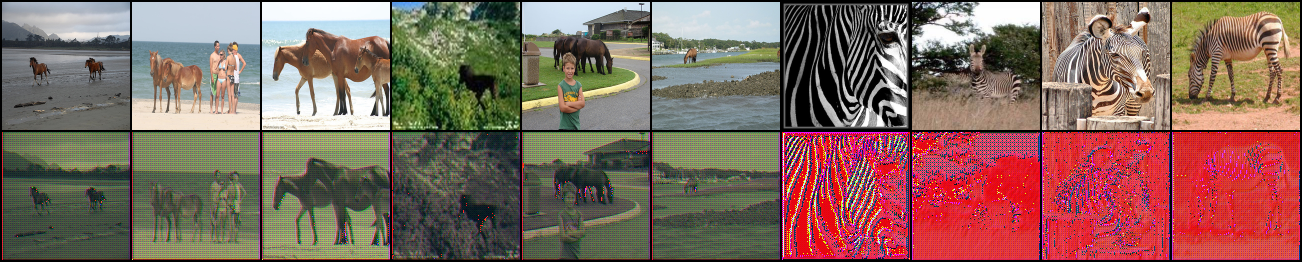

In [6]:
G, F, Dx, Dy, optG, optF, optDx, optDy = model_init()
write_image(G, F)

Epoch 1/5: 100%|██████████| 76/76 [01:17<00:00,  1.03s/it]


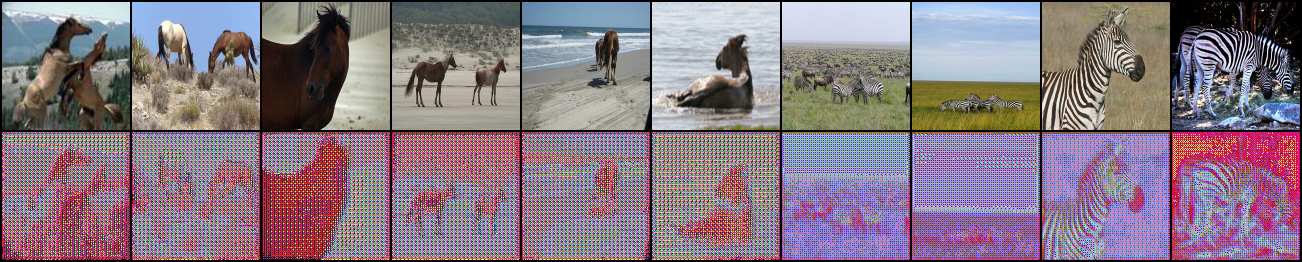

Epoch 2/5: 100%|██████████| 76/76 [01:17<00:00,  1.02s/it]


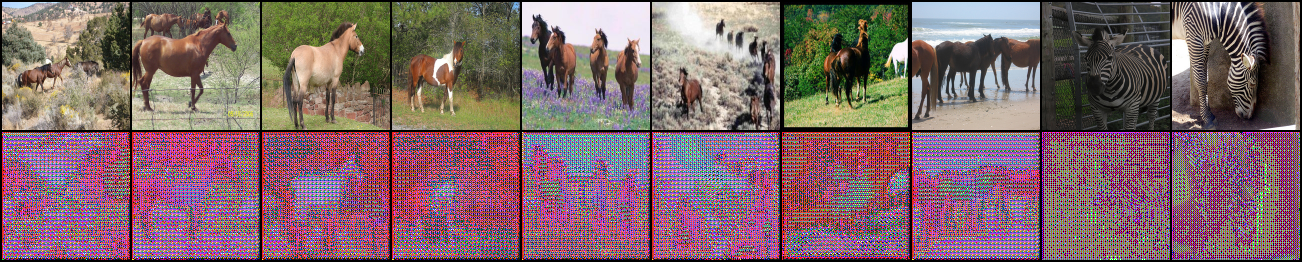

Epoch 3/5: 100%|██████████| 76/76 [01:17<00:00,  1.02s/it]


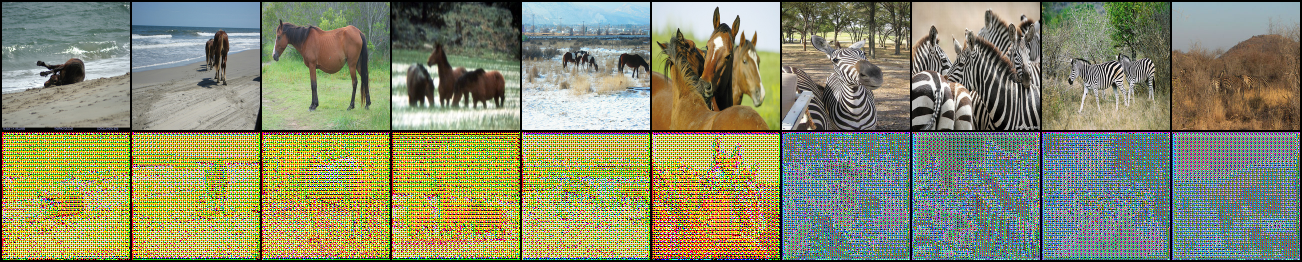

Epoch 4/5: 100%|██████████| 76/76 [01:17<00:00,  1.02s/it]


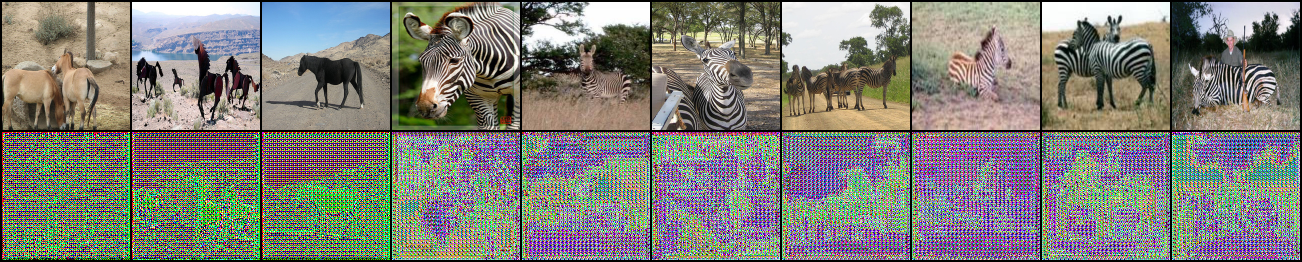

Epoch 5/5: 100%|██████████| 76/76 [01:17<00:00,  1.01s/it]


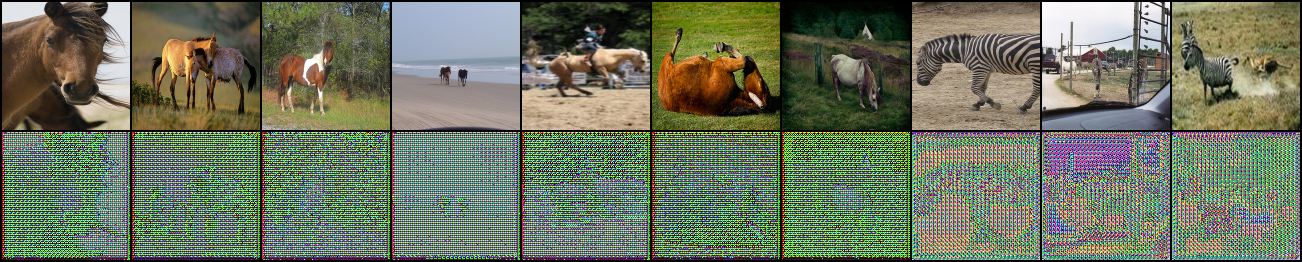

In [7]:
n_epochs = 5
train(G, F, Dx, Dy, optG, optF, optDx, optDy, dataloader, n_epochs)